<a href="https://colab.research.google.com/github/OscarSantos98/COVID_in_Mexico/blob/master/Scripts/PCA_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Guardar una copia en Drive 



###Descargar datos
https://coronavirus.gob.mx/datos/

###Crear dataframe

In [1]:
import pandas as pd
df = pd.read_csv('Casos_Diarios_Estado_Nacional_Confirmados_20200806.csv',index_col = 2) 
df.drop(['cve_ent','poblacion'], axis=1, inplace=True)
df.drop(df.loc[:,'01-08-2020':'06-08-2020'].columns, axis = 1, inplace=True)
df=df[:-1]
df.index.names = ['estado']
df.columns.names = ['fecha']
df.head()

fecha,12-01-2020,13-01-2020,14-01-2020,15-01-2020,16-01-2020,17-01-2020,18-01-2020,19-01-2020,20-01-2020,21-01-2020,22-01-2020,23-01-2020,24-01-2020,25-01-2020,26-01-2020,27-01-2020,28-01-2020,29-01-2020,30-01-2020,31-01-2020,01-02-2020,02-02-2020,03-02-2020,04-02-2020,05-02-2020,06-02-2020,07-02-2020,08-02-2020,09-02-2020,10-02-2020,11-02-2020,12-02-2020,13-02-2020,14-02-2020,15-02-2020,16-02-2020,17-02-2020,18-02-2020,19-02-2020,20-02-2020,...,22-06-2020,23-06-2020,24-06-2020,25-06-2020,26-06-2020,27-06-2020,28-06-2020,29-06-2020,30-06-2020,01-07-2020,02-07-2020,03-07-2020,04-07-2020,05-07-2020,06-07-2020,07-07-2020,08-07-2020,09-07-2020,10-07-2020,11-07-2020,12-07-2020,13-07-2020,14-07-2020,15-07-2020,16-07-2020,17-07-2020,18-07-2020,19-07-2020,20-07-2020,21-07-2020,22-07-2020,23-07-2020,24-07-2020,25-07-2020,26-07-2020,27-07-2020,28-07-2020,29-07-2020,30-07-2020,31-07-2020
estado,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AGUASCALIENTES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,68,54,50,69,56,17,11,38,39,79,69,67,11,8,92,119,53,43,77,21,32,82,83,81,87,72,22,13,51,96,50,72,72,17,20,69,59,57,56,47
BAJA CALIFORNIA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,209,193,178,171,171,112,61,207,193,173,190,160,71,91,208,182,150,151,118,47,59,141,156,162,147,127,76,85,139,120,106,106,119,69,56,114,69,83,86,67
BAJA CALIFORNIA SUR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,33,47,53,54,41,45,35,66,58,73,70,64,57,48,88,113,92,122,118,38,48,129,120,131,117,89,60,41,152,110,111,107,79,54,32,168,152,120,146,93
CAMPECHE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,104,92,85,90,94,52,47,69,89,70,92,59,31,36,79,90,91,97,107,51,54,104,62,114,104,88,44,47,104,97,84,79,79,30,21,64,81,67,55,49
CHIAPAS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,95,86,98,88,84,42,44,69,54,63,52,64,42,23,43,43,33,31,41,21,24,37,26,29,23,30,10,29,33,21,21,17,34,13,14,20,23,18,17,24


###Análisis de componentes principales

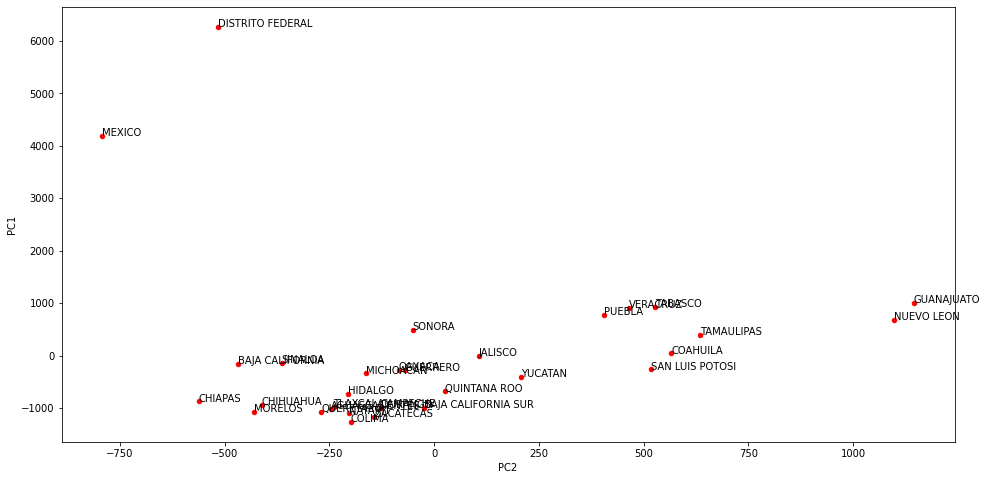

In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df)

existing_2d = pca.transform(df)
existing_df_2d = pd.DataFrame(existing_2d)
existing_df_2d.index = df.index
existing_df_2d.columns = ['PC1','PC2']

%matplotlib inline

ax = existing_df_2d.plot(kind='scatter', x='PC2', y='PC1', color='Red', figsize=(16,8))

for i, country in enumerate(df.index):
    ax.annotate(country, (existing_df_2d.iloc[i].PC2, existing_df_2d.iloc[i].PC1))

###Colores

https://matplotlib.org/3.1.0/gallery/color/named_colors.html

# Paquetes necesarios para las siguientes secciones

In [3]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

### Clustering - K-means

# Determinar el número de clústeres adecuado

Primer método

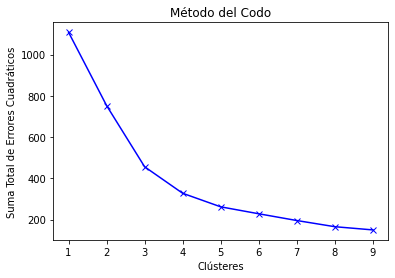

In [4]:
from scipy.spatial.distance import cdist
grupos = []
K = range(1,10)
for k in K:
  Modelokmean = KMeans(n_clusters = k).fit(existing_df_2d)
  Modelokmean.fit(existing_df_2d)
  grupos.append(sum(np.min(cdist(existing_df_2d, Modelokmean.cluster_centers_,'euclidean'),axis=1)) / existing_df_2d.shape[0])
plt.plot(K, grupos, 'bx-')
plt.xlabel('Clústeres')
plt.ylabel('Suma Total de Errores Cuadráticos')
plt.title('Método del Codo')
plt.show()

Segundo método

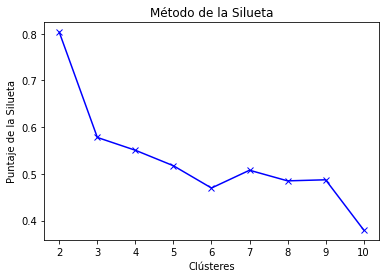

In [5]:
from sklearn.metrics import silhouette_score
silueta = []
K = range(2,11)
for k in K:
  kmeans = KMeans(n_clusters = k).fit(existing_df_2d)
  labels = kmeans.labels_
  silueta.append(silhouette_score(existing_df_2d, labels, metric = 'euclidean'))
plt.plot(K, silueta, 'bx-')
plt.xlabel('Clústeres')
plt.ylabel('Puntaje de la Silueta')
plt.title('Método de la Silueta')
plt.show()

Al analizar la gráfica del método del codo se observa que la mejor opción es agrupar por 3 o 4 clusters. Sin embargo, el método de la silueta indica que deberían ser 2 clusters.

A pesar de esto, mediante el análisis de contagios con Folium descrito en el archivo map_mex_choropleth.html se concluye que la mejor opción son 4 clústers.

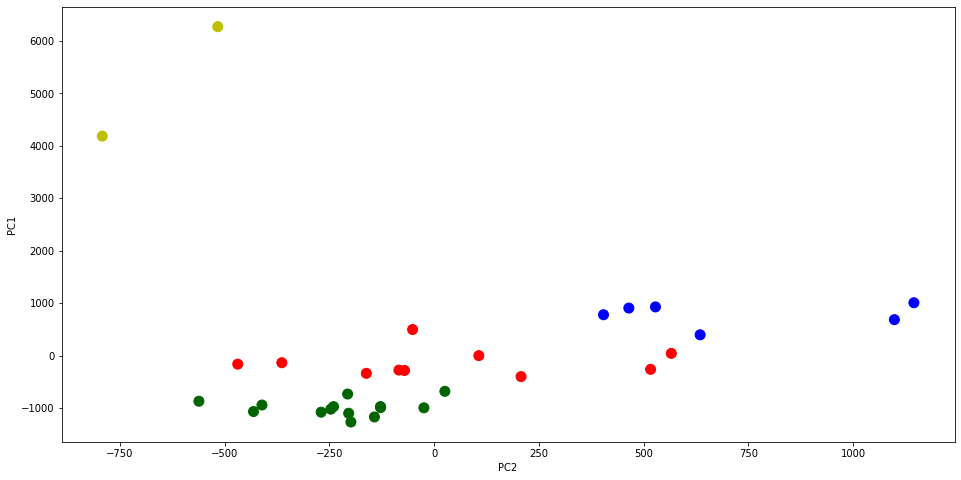

In [6]:
np.random.seed(1234)
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit(df)
existing_df_2d['cluster'] = pd.Series(clusters.labels_, index=existing_df_2d.index)

import numpy as np
styles = ['b','r','y','darkgreen']
existing_df_2d.plot(
    kind='scatter',
    x='PC2',y='PC1',
    c=[styles[i] for i in existing_df_2d.cluster.astype(np.int)],
    s=100,
    figsize=(16,8))

###Graficar promedio de casos por grupo

Text(0, 0.5, 'Casos confirmados')

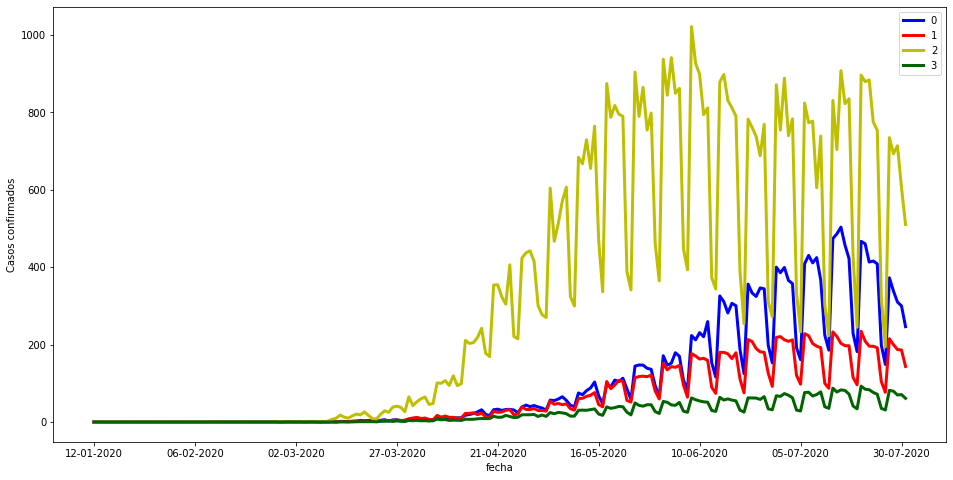

In [7]:
cluster_centers_df = pd.DataFrame(
    clusters.cluster_centers_, 
    index=['0','1','2','3']) 
cluster_centers_df.columns = df.columns

ax = cluster_centers_df.T.plot(
    figsize=(16,8),
    style=styles,
    linewidth = 3)
ax.set_ylabel("Casos confirmados")

###Identificar clusters

In [8]:
existing_df_2d[existing_df_2d.cluster == 0].index

Index(['GUANAJUATO', 'NUEVO LEON', 'PUEBLA', 'TABASCO', 'TAMAULIPAS',
       'VERACRUZ'],
      dtype='object', name='estado')